In [1]:
import pandas as pd
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torch

from SoundDataSet import CovidCoughAudio
from Model import CoughClassifier, training

In [2]:
METADATA_FILE = 'data/metadata_compiled.csv'
DATA_PATH = 'data/'

metadata_df = pd.read_csv(METADATA_FILE)

In [3]:
not_nan_df = metadata_df[metadata_df['status'].isna() == False]
filtered_df = not_nan_df[not_nan_df['cough_detected'] > 0.9]
filtered_df[['uuid', 'cough_detected', 'SNR', 'age', 'gender', 'status']]

,uuid,cough_detected,SNR,age,gender,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,0.9609,16.151433,15.0,male,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,0.9301,20.146058,34.0,male,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,0.9968,13.146502,21.0,male,healthy
11,00291cce-36a0-4a29-9e2d-c1d96ca17242,0.9883,14.603851,15.0,male,healthy
12,0029d048-898a-4c70-89c7-0815cdcf7391,1.0000,9.624196,35.0,male,symptomatic
...,...,...,...,...,...,...
27535,ffd42893-4119-4855-9aad-c67d8d392cc1,0.9414,28.530965,26.0,male,healthy
27539,ffe0658f-bade-4654-ad79-40a468aabb03,1.0000,21.960583,22.0,male,COVID-19
27540,ffe13fcf-c5c2-4a6a-a9fc-e010f4f033c1,0.9485,9.966762,31.0,male,symptomatic
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,1.0000,33.661082,23.0,male,healthy


In [4]:
filtered_df['status'].value_counts()

healthy        7075
symptomatic    1697
COVID-19        699
Name: status, dtype: int64

In [5]:
covid_dataset = CovidCoughAudio(filtered_df, DATA_PATH)

torch.Size([1, 64, 938])


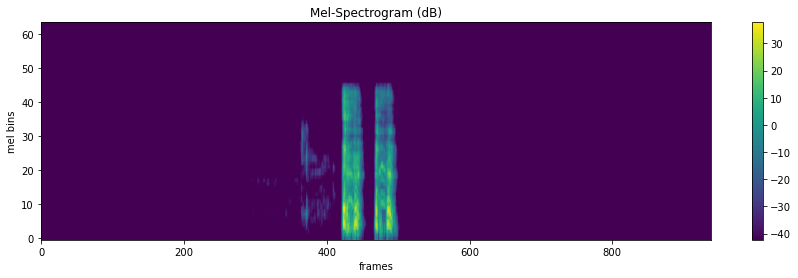

In [6]:
spec, label_id = covid_dataset[254]
print(spec.shape)

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

axs.set_title('Mel-Spectrogram (dB)')
axs.set_xlabel('frames')
axs.set_ylabel('mel bins')

im = axs.imshow(spec[0], origin='lower', aspect='auto')
fig.colorbar(im, ax=axs)

plt.show(block=False)

In [7]:
BATCH_SIZE = 32
TRAIN_SPLIT = 0.8

num_train = int(len(covid_dataset) * TRAIN_SPLIT)
num_val = len(covid_dataset) - num_train

train_dataset, val_dataset = random_split(covid_dataset, [num_train, num_val])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
model = CoughClassifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
from torchsummary import summary
summary(model, input_size=(spec.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 32, 469]             208
              ReLU-2           [-1, 8, 32, 469]               0
       BatchNorm2d-3           [-1, 8, 32, 469]              16
            Conv2d-4          [-1, 16, 16, 235]           1,168
              ReLU-5          [-1, 16, 16, 235]               0
       BatchNorm2d-6          [-1, 16, 16, 235]              32
            Conv2d-7           [-1, 32, 8, 118]           4,640
              ReLU-8           [-1, 32, 8, 118]               0
       BatchNorm2d-9           [-1, 32, 8, 118]              64
           Conv2d-10            [-1, 64, 4, 59]          18,496
             ReLU-11            [-1, 64, 4, 59]               0
      BatchNorm2d-12            [-1, 64, 4, 59]             128
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14                   

In [ ]:
training(model, train_dataloader, 2)

In [ ]:
# TODO - Create a function to test the model
covid_dataset.label_encoder.inverse_transform(outputs.argmax(dim=1).cpu().numpy())

array(['symptomatic', 'COVID-19', 'symptomatic', 'symptomatic',
       'symptomatic', 'symptomatic', 'healthy', 'symptomatic',
       'symptomatic', 'healthy', 'COVID-19', 'healthy', 'healthy',
       'COVID-19', 'COVID-19', 'symptomatic', 'healthy', 'symptomatic',
       'symptomatic', 'COVID-19', 'COVID-19', 'COVID-19', 'symptomatic',
       'symptomatic', 'COVID-19', 'COVID-19', 'symptomatic', 'COVID-19',
       'symptomatic', 'symptomatic', 'symptomatic', 'symptomatic'],
      dtype=object)